# Facies classification utilizing an Adaptive Boosted Random Forest


[Ryan Thielke](http://www.linkedin.com/in/ryan-thielke-b987012a)


In the following, we provide a possible solution to the facies classification problem described in https://github.com/seg/2016-ml-contest.


## Exploring the data

In [1]:
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

import sys
sys.path.append("..")

#Import standard pydata libs
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [2]:
filename = '../facies_vectors.csv'
training_data = pd.read_csv(filename)
training_data['Well Name'] = training_data['Well Name'].astype('category')
training_data['Formation'] = training_data['Formation'].astype('category')                            
training_data.describe()

,Facies,Depth,GR,ILD_log10,DeltaPHI,PHIND,PE,NM_M,RELPOS
count,4149.000000,4149.000000,4149.000000,4149.000000,4149.000000,4149.000000,3232.000000,4149.000000,4149.000000
mean,4.503254,2906.867438,64.933985,0.659566,4.402484,13.201066,3.725014,1.518438,0.521852
std,2.474324,133.300164,30.302530,0.252703,5.274947,7.132846,0.896152,0.499720,0.286644
min,1.000000,2573.500000,10.149000,-0.025949,-21.832000,0.550000,0.200000,1.000000,0.000000
25%,2.000000,2821.500000,44.730000,0.498000,1.600000,8.500000,NaN,1.000000,0.277000
50%,4.000000,2932.500000,64.990000,0.639000,4.300000,12.020000,NaN,2.000000,0.528000
75%,6.000000,3007.000000,79.438000,0.822000,7.500000,16.050000,NaN,2.000000,0.769000
max,9.000000,3138.000000,361.150000,1.800000,19.312000,84.400000,8.094000,2.000000,1.000000


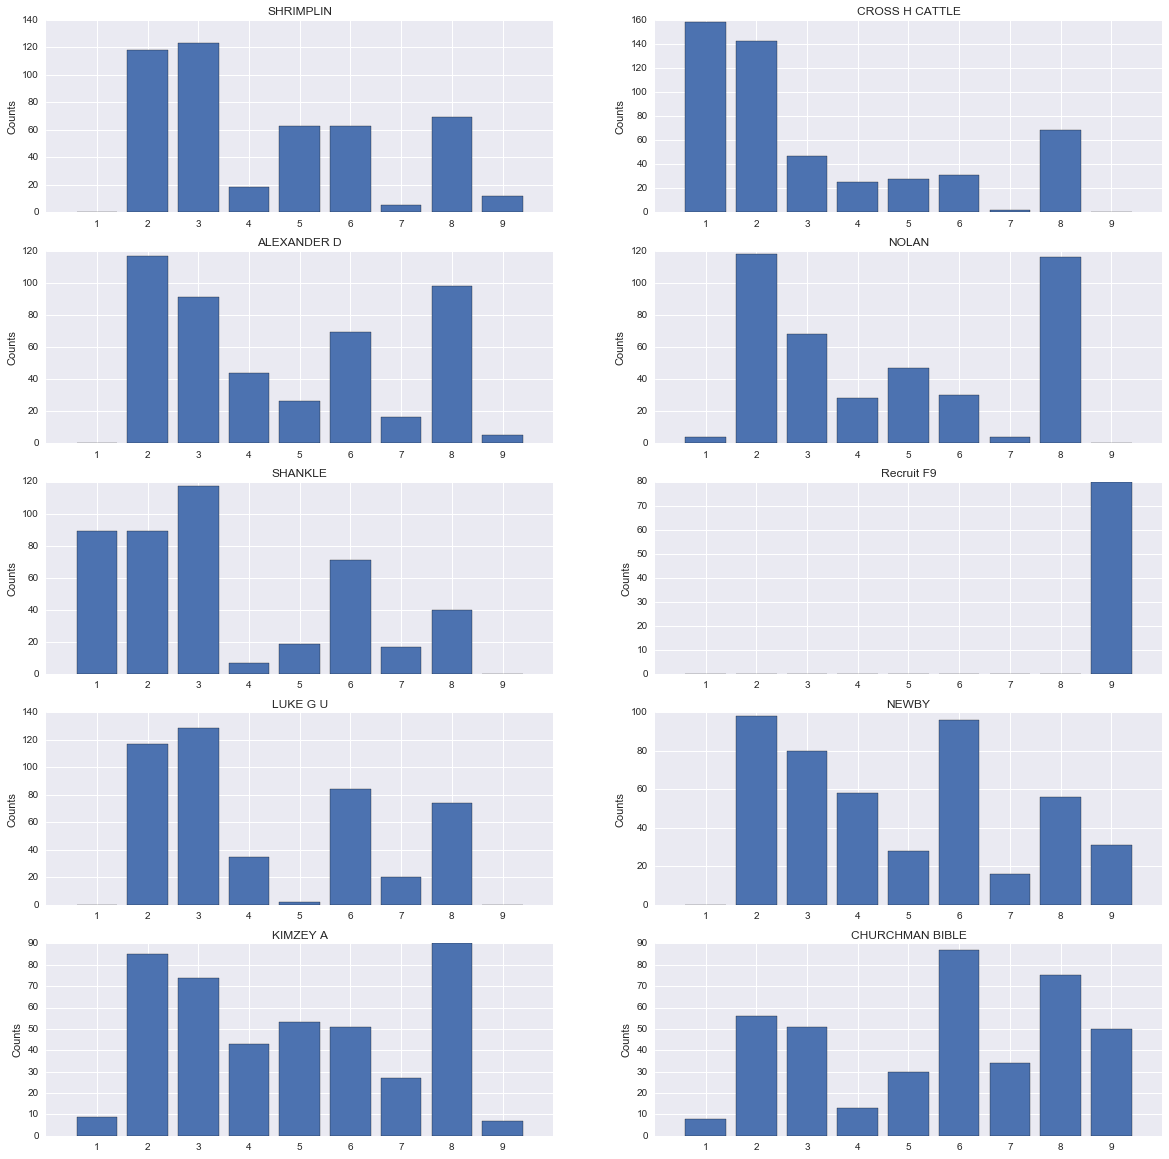

In [3]:
#Visualize the distribution of facies for each well
wells = training_data['Well Name'].unique()

fig, ax = plt.subplots(5,2, figsize=(20,20))
for i, well in enumerate(wells):
    row = i % ax.shape[0]
    column = i // ax.shape[0]
    counts = training_data[training_data['Well Name']==well].Facies.value_counts()
    data_for_well = [counts[j] if j in counts.index else 0 for j in range(1,10)]
    ax[row, column].bar(range(1,10), data_for_well, align='center')
    ax[row, column].set_title("{well}".format(well=well))
    ax[row, column].set_ylabel("Counts")
    ax[row, column].set_xticks(range(1,10))

plt.show()
    

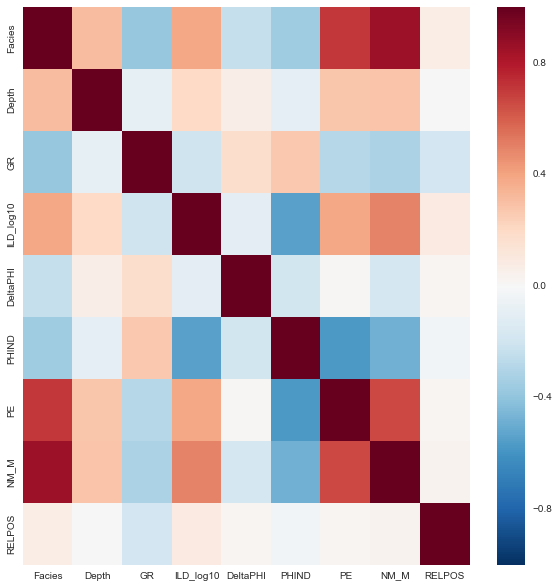

In [4]:
plt.figure(figsize=(10,10))
sns.heatmap(training_data.drop(['Formation', 'Well Name'], axis=1).corr())

# Feature Engineering

Here we will do a couple things to clean the data and attempt to create new features for our model to consume.

First, we will smooth the PE and GR features.
Second, we replace missing PE values with the mean of the entire dataset (might want to investigate other methods)
Last, we will encode the formations into integer values

In [5]:
dfs = []
for well in training_data['Well Name'].unique():
    df = training_data[training_data['Well Name']==well].copy(deep=True)
    df.sort_values('Depth', inplace=True)
    for col in ['PE', 'GR']:
        smooth_col = 'smooth_'+col
        df[smooth_col] = pd.rolling_mean(df[col], window=25)
        df[smooth_col].fillna(method='ffill', inplace=True)
        df[smooth_col].fillna(method='bfill', inplace=True)
    dfs.append(df)
training_data = pd.concat(dfs)
pe_mean = training_data.PE.mean()
sm_pe_mean = training_data.smooth_PE.mean()
training_data['PE'] = training_data.PE.replace({np.nan:pe_mean})
training_data['smooth_PE'] = training_data['smooth_PE'].replace({np.nan:sm_pe_mean})
formation_encoder = dict(zip(training_data.Formation.unique(), range(len(training_data.Formation.unique()))))
training_data['enc_formation'] = training_data.Formation.map(formation_encoder)

In [6]:
training_data.describe()

,Facies,Depth,GR,ILD_log10,DeltaPHI,PHIND,PE,NM_M,RELPOS,smooth_PE,smooth_GR,enc_formation
count,4149.000000,4149.000000,4149.000000,4149.000000,4149.000000,4149.000000,4149.000000,4149.000000,4149.000000,4149.000000,4149.000000,4149.000000
mean,4.503254,2906.867438,64.933985,0.659566,4.402484,13.201066,3.725014,1.518438,0.521852,3.707428,65.006645,6.476982
std,2.474324,133.300164,30.302530,0.252703,5.274947,7.132846,0.790917,0.499720,0.286644,0.577399,17.544534,4.819176
min,1.000000,2573.500000,10.149000,-0.025949,-21.832000,0.550000,0.200000,1.000000,0.000000,2.552000,22.672680,0.000000
25%,2.000000,2821.500000,44.730000,0.498000,1.600000,8.500000,3.200000,1.000000,0.277000,3.329280,53.656400,2.000000
50%,4.000000,2932.500000,64.990000,0.639000,4.300000,12.020000,3.725014,2.000000,0.528000,3.707428,65.104800,6.000000
75%,6.000000,3007.000000,79.438000,0.822000,7.500000,16.050000,4.000000,2.000000,0.769000,3.916000,75.716000,12.000000
max,9.000000,3138.000000,361.150000,1.800000,19.312000,84.400000,8.094000,2.000000,1.000000,6.086440,134.212600,13.000000


## Building the model and parameter tuning

In the section below we will create a Adaptive Boosted Random Forest Classifier from the Scikit-Learn ML Library

In [7]:
#Let's build a model
from sklearn import preprocessing
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics, cross_validation 
from classification_utilities import display_cm

In [9]:
#We will take a look at an F1 score for each well
n_estimators=100
learning_rate=.01
random_state=0
facies_labels = ['SS', 'CSiS', 'FSiS', 'SiSh', 'MS',
                 'WS', 'D','PS', 'BS']

title_length = 20 

wells = training_data['Well Name'].unique()
for well in wells:
    blind = training_data[training_data['Well Name']==well]
    train = training_data[(training_data['Well Name']!=well)]
    
    train_X = train.drop(['Formation', 'Well Name', 'Depth', 'Facies'], axis=1)
    train_Y = train.Facies.values
    test_X = blind.drop(['Formation', 'Well Name', 'Facies', 'Depth'], axis=1)
    test_Y = blind.Facies.values
    
    clf = AdaBoostClassifier(RandomForestClassifier(), n_estimators=200, learning_rate=learning_rate, random_state=random_state, algorithm='SAMME.R')
    clf.fit(X=train_X, y=train_Y)
    pred_Y = clf.predict(test_X)
    f1 = metrics.f1_score(test_Y, pred_Y, average='micro')
    print("*"*title_length)
    print("{well}={f1:.4f}".format(well=well,f1=f1))
    print("*"*title_length)


********************
SHRIMPLIN=0.6306
********************
********************
ALEXANDER D=0.6738
********************
********************
SHANKLE=0.4477
********************
********************
LUKE G U=0.6334
********************
********************
KIMZEY A=0.5148
********************
********************
CROSS H CATTLE=0.4331
********************
********************
NOLAN=0.4892
********************
********************
Recruit F9=0.6750
********************
********************
NEWBY=0.4320
********************
********************
CHURCHMAN BIBLE=0.5248
********************


In [10]:
train_X, test_X, train_Y, test_Y = cross_validation.train_test_split(training_data.drop(['Formation', 'Well Name','Facies', 'Depth'], axis=1), training_data.Facies.values, test_size=.2)

In [11]:
print(train_X.shape)
print(train_Y.shape)
print(test_X.shape)
print(test_Y.shape)

(3319, 10)
(3319,)
(830, 10)
(830,)


In [12]:
clf = AdaBoostClassifier(RandomForestClassifier(), n_estimators=200, learning_rate=learning_rate, random_state=0, algorithm='SAMME.R')

clf.fit(train_X, train_Y)
pred_Y = clf.predict(test_X)
cm = metrics.confusion_matrix(y_true=test_Y, y_pred=pred_Y)
display_cm(cm, facies_labels, display_metrics=True)

     Pred    SS  CSiS  FSiS  SiSh    MS    WS     D    PS    BS Total
     True
       SS    50    16     1     0     0     0     0     0     0    67
     CSiS     2   164    25     0     0     0     0     1     0   192
     FSiS     0    18   134     0     0     2     0     1     0   155
     SiSh     0     0     1    53     0     4     0     2     0    60
       MS     0     2     2     4    31    11     1     9     0    60
       WS     0     0     2     5     3    81     1    19     1   112
        D     0     0     1     0     1     0    22     6     0    30
       PS     0     0     3     1     1     9     0    98     0   112
       BS     0     0     0     0     0     1     0     2    39    42

Precision  0.96  0.82  0.79  0.84  0.86  0.75  0.92  0.71  0.97  0.82
   Recall  0.75  0.85  0.86  0.88  0.52  0.72  0.73  0.88  0.93  0.81
       F1  0.84  0.84  0.83  0.86  0.65  0.74  0.81  0.78  0.95  0.81


In [13]:
validation_data = pd.read_csv("../validation_data_nofacies.csv")

In [14]:
dfs = []
for well in validation_data['Well Name'].unique():
    df = validation_data[validation_data['Well Name']==well].copy(deep=True)
    df.sort_values('Depth', inplace=True)
    for col in ['PE', 'GR']:
        smooth_col = 'smooth_'+col
        df[smooth_col] = pd.rolling_mean(df[col], window=25)
        df[smooth_col].fillna(method='ffill', inplace=True)
        df[smooth_col].fillna(method='bfill', inplace=True)
    dfs.append(df)
validation_data = pd.concat(dfs)

validation_data['enc_formation'] = validation_data.Formation.map(formation_encoder)
validation_data.describe()

,Depth,GR,ILD_log10,DeltaPHI,PHIND,PE,NM_M,RELPOS,smooth_PE,smooth_GR,enc_formation
count,830.000000,830.00000,830.000000,830.000000,830.000000,830.000000,830.000000,830.000000,830.000000,830.000000,830.000000
mean,2987.070482,57.61173,0.666312,2.851964,11.655277,3.654178,1.678313,0.535807,3.640066,57.535834,6.214458
std,94.391925,27.52774,0.288367,3.442074,5.190236,0.649793,0.467405,0.283062,0.373720,16.020556,4.599762
min,2808.000000,12.03600,-0.468000,-8.900000,1.855000,2.113000,1.000000,0.013000,2.783080,23.462960,0.000000
25%,2911.625000,36.77325,0.541000,0.411250,7.700000,3.171500,1.000000,0.300000,3.386970,46.641210,1.000000
50%,2993.750000,58.34450,0.675000,2.397500,10.950000,3.515500,2.000000,0.547500,3.631880,56.626940,5.000000
75%,3055.375000,73.05150,0.850750,4.600000,14.793750,4.191500,2.000000,0.778000,3.846550,68.118700,11.000000
max,3160.500000,220.41300,1.507000,16.500000,31.335000,6.321000,2.000000,1.000000,4.696200,95.138680,13.000000


In [15]:
X = training_data.drop(['Formation', 'Well Name', 'Depth','Facies'], axis=1)
Y = training_data.Facies.values
test_X = validation_data.drop(['Formation', 'Well Name', 'Depth'], axis=1)

clf = AdaBoostClassifier(RandomForestClassifier(), n_estimators=200, learning_rate=learning_rate, random_state=0)
clf.fit(X,Y)
predicted_facies = clf.predict(test_X)
validation_data['Facies'] = predicted_facies

In [16]:
validation_data.to_csv("Kr1m_SEG_ML_Attempt1.csv")